In [2]:
using Revise
using DifferentialEquations
using Flux
using DiffEqFlux
using Optim
using Plots
using FileIO
using JLD2
using OffsetArrays
using Kinetic

In [3]:
function bgk!(df, f, p, t)
    g, tau = p
    df .= (g .- f) ./ tau
end

bgk! (generic function with 1 method)

In [4]:
D = read_dict("../code/shock/shock1D.txt")
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

case = shock
space = 1d1f1v
nSpecies = 1
interpOrder = 1
limiter = vanleer
cfl = 0.95
maxTime = 250.0
x0 = -25.0
x1 = 25.0
nx = 50
pMeshType = uniform
nxg = 0
umin = -10.0
umax = 10.0
nu = 36
nug = 0
vMeshType = rectangle
knudsen = 1.0
mach = 2.0
prandtl = 1.0
inK = 0.0
omega = 0.5
alphaRef = 1.0
omegaRef = 0.5
tLen = 5
nh = 12



In [5]:
γ = 3.
set = Setup(case, space, nSpecies, interpOrder, limiter, cfl, maxTime)
pSpace = PSpace1D(x0, x1, nx, pMeshType, nxg)
μᵣ = ref_vhs_vis(knudsen, alphaRef, omegaRef)
gas = GasProperty(knudsen, mach, prandtl, inK, γ, omega, alphaRef, omegaRef, μᵣ)
vSpace = VSpace1D(umin, umax, nu, vMeshType, nug)
wL, primL, fL, bcL, wR, primR, fR, bcR = ib_rh(mach, γ, vSpace.u)
ib = IB1D1F(wL, primL, fL, bcL, wR, primR, fR, bcR)

ks = SolverSet(set, pSpace, vSpace, gas, ib, pwd());

In [6]:
ctr = OffsetArray{ControlVolume1D1F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D1F}(undef, ks.pSpace.nx+1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx÷2
        ctr[i] = ControlVolume1D1F(ks.pSpace.x[i], ks.pSpace.dx[i], Float32.(ks.ib.wL), Float32.(ks.ib.primL), Float32.(ks.ib.fL))
    else
        ctr[i] = ControlVolume1D1F(ks.pSpace.x[i], ks.pSpace.dx[i], Float32.(ks.ib.wR), Float32.(ks.ib.primR), Float32.(ks.ib.fR))
    end
end
for i=1:ks.pSpace.nx+1
    face[i] = Interface1D1F(ks.ib.fL)
end

In [7]:
sos = sound_speed(ks.ib.primR, γ)
vmax = ks.vSpace.u1 + sos
tmax = vmax / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tSpan = (0.f0, dt)
tRan = range(tSpan[1], tSpan[2], length=tLen)

0.0f0:0.01935499f0:0.07741996f0

In [8]:
residual = Array{Float32}(undef, 3)
for iter=1:1000
    Kinetic.evolve!(ks, ctr, face, dt)
    Kinetic.update!(ks, ctr, face, dt, residual)
end

In [9]:
X = Array{Float32}(undef, nu, nx);
for i in 1:nx
    X[:,i] .= ctr[i].f
end

In [10]:
M = Array{Float32}(undef, nu, nx)
τ = Array{Float32}(undef, nx)
for i=1:nx
    M[:,i] .= maxwellian(ks.vSpace.u, ctr[i].prim)
    τ = vhs_collision_time(ctr[i].prim, ks.gas.μᵣ, ks.gas.ω)
end

data_para = [M, τ];

In [11]:
prob = ODEProblem(bgk!, X, tSpan, data_para)
Y = solve(prob, Tsit5(), saveat=tRan) |> Array;

In [12]:
dudt = FastChain( (x, p) -> x.^3,
                   FastDense(vSpace.nu, vSpace.nu*16, tanh),
                   #FastDense(vSpace.nu*16, vSpace.nu*16, tanh),
                   FastDense(vSpace.nu*16, vSpace.nu) )
#node = NeuralODE(dudt, tSpan, Tsit5(), saveat=tRan)
node = NeuralODE(dudt, tSpan, Tsit5(), saveat=tRan)

(::NeuralODE{FastChain{Tuple{var"#3#4",FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#76"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(identity),DiffEqFlux.var"#initial_params#76"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}}}},Array{Float32,1},Nothing,Tuple{Float32,Float32},Tsit5,Tuple{},Base.Iterators.Pairs{Symbol,StepRangeLen{Float32,Float64,Float64},Tuple{Symbol},NamedTuple{(:saveat,),Tuple{StepRangeLen{Float32,Float64,Float64}}}}}) (generic function with 4 methods)

In [13]:
function loss_node(p) # without dataset
    diff = Array(node(X, p)) .- Y
    loss = sum(abs2, diff)
    return loss
end

loss_node (generic function with 1 method)

In [14]:
cb = function (p, l)
    display(l)
    return false
end

#5 (generic function with 1 method)

In [15]:
#res = DiffEqFlux.sciml_train(loss_node, node.p, ADAM(), dataset, cb=cb, maxiters=100)
res = DiffEqFlux.sciml_train(loss_node, node.p, ADAM(), cb=Flux.throttle(cb, 1), maxiters=1000)

0.006096926f0

loss: 0.00288:   0%|▏                                        |  ETA: 9:21:48

0.0025600512f0

loss: 0.00198:   1%|▎                                        |  ETA: 2:43:34

0.0018480868f0

loss: 0.00226:   1%|▌                                        |  ETA: 1:45:45

0.002178588f0

loss: 0.00157:   2%|▋                                        |  ETA: 1:14:02

0.0016108784f0

loss: 0.0016:   2%|▉                                        |  ETA: 1:00:10m

0.0015129928f0

loss: 0.00139:   2%|█                                        |  ETA: 0:50:53

0.0013988629f0

loss: 0.00132:   3%|█▏                                       |  ETA: 0:44:14

0.0012657829f0

loss: 0.00117:   3%|█▍                                       |  ETA: 0:38:10

0.0011537895f0

loss: 0.00106:   4%|█▌                                       |  ETA: 0:34:29

0.0010302052f0

loss: 0.000955:   4%|█▊                                       |  ETA: 0:30:51

0.000926157f0

loss: 0.000831:   5%|█▉                                       |  ETA: 0:27:59

0.00081362063f0

loss: 0.000723:   5%|██▏                                      |  ETA: 0:25:42

0.0007025298f0

loss: 0.000624:   6%|██▍                                      |  ETA: 0:23:48

0.0006034004f0

loss: 0.000533:   6%|██▌                                      |  ETA: 0:22:11

0.0005150799f0

loss: 0.000449:   7%|██▊                                      |  ETA: 0:20:50

0.00043393773f0

loss: 0.000377:   7%|███                                      |  ETA: 0:19:39

0.00036428892f0

loss: 0.000317:   8%|███▏                                     |  ETA: 0:18:37

0.0003061812f0

loss: 0.000268:   8%|███▍                                     |  ETA: 0:17:43

0.0002597823f0

loss: 0.00023:   9%|███▋                                     |  ETA: 0:16:54m

0.00022326034f0

loss: 0.0002:   9%|███▊                                     |  ETA: 0:16:109m

0.00019512931f0

loss: 0.000181:  10%|███▉                                     |  ETA: 0:15:39

0.0001774072f0

loss: 0.000163:  10%|████▏                                    |  ETA: 0:15:04

0.0001598857f0

loss: 0.000149:  11%|████▍                                    |  ETA: 0:14:31

0.0001462896f0

loss: 0.00014:  11%|████▌                                    |  ETA: 0:14:07m

0.00013752592f0

loss: 0.000132:  11%|████▋                                    |  ETA: 0:13:45

0.00013022359f0

loss: 0.000126:  12%|████▉                                    |  ETA: 0:13:24

0.00012406721f0

loss: 0.00012:  12%|█████                                    |  ETA: 0:13:04m

0.00011882578f0

loss: 0.000114:  13%|█████▎                                   |  ETA: 0:12:41

0.00011330555f0

loss: 0.00011:  13%|█████▍                                   |  ETA: 0:12:19m

0.00010871506f0

loss: 0.000106:  14%|█████▋                                   |  ETA: 0:11:58

0.00010490635f0

loss: 0.000103:  14%|█████▉                                   |  ETA: 0:11:39

0.00010448633f0

loss: 0.000118:  15%|██████                                   |  ETA: 0:11:22

0.00010395398f0

loss: 0.000101:  15%|██████▎                                  |  ETA: 0:11:05

9.77268f-5

loss: 9.75e-05:  16%|██████▍                                  |  ETA: 0:10:49

0.00010117068f0

loss: 9.72e-05:  16%|██████▋                                  |  ETA: 0:10:37

9.787724f-5

loss: 9.49e-05:  17%|██████▊                                  |  ETA: 0:10:23

9.281662f-5

loss: 9.28e-05:  17%|███████                                  |  ETA: 0:10:12

9.195592f-5

loss: 9.16e-05:  17%|███████▏                                 |  ETA: 0:10:02

9.128395f-5

loss: 9.07e-05:  18%|███████▎                                 |  ETA: 0:09:52

9.059724f-5

loss: 9e-05:  18%|███████▌                                 |  ETA: 0:09:4339m

8.990006f-5

loss: 8.92e-05:  19%|███████▋                                 |  ETA: 0:09:31

8.93035f-5

loss: 8.86e-05:  19%|███████▉                                 |  ETA: 0:09:20

8.854479f-5

loss: 8.79e-05:  20%|████████▏                                |  ETA: 0:09:10

8.7803666f-5

loss: 8.73e-05:  20%|████████▎                                |  ETA: 0:09:02

8.7251436f-5

loss: 8.67e-05:  21%|████████▌                                |  ETA: 0:08:52

8.659447f-5

loss: 8.62e-05:  21%|████████▋                                |  ETA: 0:08:45

8.606473f-5

loss: 8.57e-05:  21%|████████▊                                |  ETA: 0:08:38

8.560608f-5

loss: 8.52e-05:  22%|█████████                                |  ETA: 0:08:31

8.511102f-5

loss: 8.48e-05:  22%|█████████▏                               |  ETA: 0:08:24

8.463246f-5

loss: 8.41e-05:  23%|█████████▎                               |  ETA: 0:08:16

8.403049f-5

loss: 8.37e-05:  23%|█████████▌                               |  ETA: 0:08:09

8.355649f-5

loss: 8.31e-05:  24%|█████████▋                               |  ETA: 0:08:01

8.294991f-5

loss: 8.25e-05:  24%|█████████▉                               |  ETA: 0:07:54

8.2353f-5

loss: 8.2e-05:  24%|██████████                               |  ETA: 0:07:48m

8.194965f-5

loss: 8.21e-05:  25%|██████████▎                              |  ETA: 0:07:43

8.2593964f-5

loss: 9.1e-05:  25%|██████████▍                              |  ETA: 0:07:37m

9.974383f-5

loss: 0.000114:  26%|██████████▌                              |  ETA: 0:07:32

9.205707f-5

loss: 0.000101:  26%|██████████▊                              |  ETA: 0:07:27

9.542296f-5

loss: 9.13e-05:  26%|██████████▉                              |  ETA: 0:07:21

9.107622f-5

loss: 8.63e-05:  27%|███████████                              |  ETA: 0:07:16

8.701118f-5

loss: 8.34e-05:  27%|███████████▎                             |  ETA: 0:07:12

8.405154f-5

loss: 8.13e-05:  28%|███████████▍                             |  ETA: 0:07:07

8.1957434f-5

loss: 7.98e-05:  28%|███████████▌                             |  ETA: 0:07:02

8.041356f-5

loss: 7.92e-05:  29%|███████████▊                             |  ETA: 0:06:56

7.833356f-5

loss: 7.78e-05:  29%|███████████▉                             |  ETA: 0:06:50

7.70202f-5

loss: 7.68e-05:  30%|████████████▏                            |  ETA: 0:06:44

7.628841f-5

loss: 7.6e-05:  30%|████████████▍                            |  ETA: 0:06:39m

7.57105f-5

loss: 7.54e-05:  31%|████████████▌                            |  ETA: 0:06:34

7.515511f-5

loss: 7.5e-05:  31%|████████████▊                            |  ETA: 0:06:29m

7.4813615f-5

loss: 7.43e-05:  32%|████████████▉                            |  ETA: 0:06:24

7.422124f-5

loss: 7.37e-05:  32%|█████████████▏                           |  ETA: 0:06:19

7.358318f-5

loss: 7.31e-05:  32%|█████████████▍                           |  ETA: 0:06:14

7.2974144f-5

loss: 7.25e-05:  33%|█████████████▌                           |  ETA: 0:06:09

7.242929f-5

loss: 7.21e-05:  33%|█████████████▊                           |  ETA: 0:06:06

7.193629f-5

loss: 7.16e-05:  34%|█████████████▉                           |  ETA: 0:06:02

7.1479364f-5

loss: 7.11e-05:  34%|██████████████                           |  ETA: 0:05:58

7.1028924f-5

loss: 7.07e-05:  35%|██████████████▏                          |  ETA: 0:05:55

7.058741f-5

loss: 7.03e-05:  35%|██████████████▍                          |  ETA: 0:05:50

7.025276f-5

loss: 7.1e-05:  36%|██████████████▌                          |  ETA: 0:05:46m

7.2024035f-5

loss: 9.46e-05:  36%|██████████████▊                          |  ETA: 0:05:41

0.00010829094f0

loss: 7.1e-05:  36%|███████████████                          |  ETA: 0:05:37m

7.1603376f-5

loss: 6.95e-05:  37%|███████████████▏                         |  ETA: 0:05:33

7.0576934f-5

loss: 6.76e-05:  38%|███████████████▍                         |  ETA: 0:05:29

7.1647126f-5

loss: 6.78e-05:  38%|███████████████▋                         |  ETA: 0:05:24

7.157074f-5

loss: 6.8e-05:  38%|███████████████▊                         |  ETA: 0:05:20m

7.0094626f-5

loss: 6.75e-05:  39%|████████████████                         |  ETA: 0:05:16

6.8336754f-5

loss: 6.58e-05:  39%|████████████████▏                        |  ETA: 0:05:13

6.6557266f-5

loss: 6.53e-05:  40%|████████████████▍                        |  ETA: 0:05:10

6.5148495f-5

loss: 6.55e-05:  40%|████████████████▌                        |  ETA: 0:05:07

6.4857966f-5

loss: 6.48e-05:  41%|████████████████▋                        |  ETA: 0:05:03

6.4428365f-5

loss: 6.4e-05:  41%|████████████████▉                        |  ETA: 0:04:59m

6.3905216f-5

loss: 6.32e-05:  42%|█████████████████▏                       |  ETA: 0:04:55

6.316644f-5

loss: 6.27e-05:  42%|█████████████████▎                       |  ETA: 0:04:52

6.25016f-5

loss: 6.22e-05:  43%|█████████████████▌                       |  ETA: 0:04:48

6.205487f-5

loss: 6.15e-05:  43%|█████████████████▊                       |  ETA: 0:04:45

6.140517f-5

loss: 6.1e-05:  44%|█████████████████▉                       |  ETA: 0:04:41m

6.0904335f-5

loss: 6.05e-05:  44%|██████████████████▏                      |  ETA: 0:04:38

6.0424834f-5

loss: 6.02e-05:  45%|██████████████████▍                      |  ETA: 0:04:34

6.0267135f-5

loss: 6.27e-05:  45%|██████████████████▌                      |  ETA: 0:04:31

6.4905915f-5

loss: 0.000101:  46%|██████████████████▊                      |  ETA: 0:04:27

0.00011489912f0

loss: 5.84e-05:  46%|███████████████████                      |  ETA: 0:04:24

6.794647f-5

loss: 5.85e-05:  47%|███████████████████▏                     |  ETA: 0:04:21

6.199953f-5

loss: 5.77e-05:  47%|███████████████████▍                     |  ETA: 0:04:17

6.087087f-5

loss: 5.72e-05:  48%|███████████████████▌                     |  ETA: 0:04:14

5.9871545f-5

loss: 5.68e-05:  48%|███████████████████▊                     |  ETA: 0:04:11

5.850682f-5

loss: 5.62e-05:  49%|████████████████████                     |  ETA: 0:04:08

5.7107638f-5

loss: 5.57e-05:  49%|████████████████████▏                    |  ETA: 0:04:04

5.5922785f-5

loss: 5.53e-05:  50%|████████████████████▍                    |  ETA: 0:04:01

5.5075616f-5

loss: 5.51e-05:  50%|████████████████████▋                    |  ETA: 0:03:58

5.467636f-5

loss: 5.46e-05:  51%|████████████████████▊                    |  ETA: 0:03:55

5.44438f-5

loss: 5.38e-05:  51%|█████████████████████                    |  ETA: 0:03:53

5.373f-5

loss: 5.36e-05:  52%|█████████████████████▏                   |  ETA: 0:03:50

5.344039f-5

loss: 5.3e-05:  52%|█████████████████████▎                   |  ETA: 0:03:48m

5.2868167f-5

loss: 5.27e-05:  52%|█████████████████████▌                   |  ETA: 0:03:46

5.2597614f-5

loss: 5.21e-05:  53%|█████████████████████▋                   |  ETA: 0:03:43

5.2000687f-5

loss: 5.16e-05:  53%|█████████████████████▉                   |  ETA: 0:03:40

5.1448224f-5

loss: 5.1e-05:  54%|██████████████████████                   |  ETA: 0:03:37m

5.0949147f-5

loss: 5.06e-05:  54%|██████████████████████▎                  |  ETA: 0:03:34

5.0525596f-5

loss: 5.11e-05:  55%|██████████████████████▌                  |  ETA: 0:03:31

5.1931107f-5

loss: 6.63e-05:  55%|██████████████████████▋                  |  ETA: 0:03:29

8.2973296f-5

loss: 0.000184:  56%|██████████████████████▊                  |  ETA: 0:03:27

0.00015647186f0

loss: 8.68e-05:  56%|███████████████████████                  |  ETA: 0:03:24

0.000118815355f0

loss: 6.71e-05:  56%|███████████████████████▏                 |  ETA: 0:03:22

9.211339f-5

loss: 6.43e-05:  57%|███████████████████████▎                 |  ETA: 0:03:20

7.696628f-5

loss: 6.53e-05:  57%|███████████████████████▌                 |  ETA: 0:03:17

5.1144663f-5

loss: 4.83e-05:  58%|███████████████████████▊                 |  ETA: 0:03:14

5.2502866f-5

loss: 5.24e-05:  58%|███████████████████████▉                 |  ETA: 0:03:12

5.3252643f-5

loss: 5.05e-05:  59%|████████████████████████▏                |  ETA: 0:03:09

4.7513553f-5

loss: 4.7e-05:  59%|████████████████████████▍                |  ETA: 0:03:06m

4.766489f-5

loss: 4.71e-05:  60%|████████████████████████▌                |  ETA: 0:03:04

4.7775076f-5

loss: 4.7e-05:  60%|████████████████████████▊                |  ETA: 0:03:01m

4.6586483f-5

loss: 4.61e-05:  61%|████████████████████████▉                |  ETA: 0:02:58

4.5682445f-5

loss: 4.57e-05:  61%|█████████████████████████▏               |  ETA: 0:02:56

4.5403027f-5

loss: 4.53e-05:  62%|█████████████████████████▎               |  ETA: 0:02:54

4.510599f-5

loss: 4.48e-05:  62%|█████████████████████████▍               |  ETA: 0:02:52

4.475617f-5

loss: 4.44e-05:  62%|█████████████████████████▋               |  ETA: 0:02:50

4.435119f-5

loss: 4.39e-05:  63%|█████████████████████████▊               |  ETA: 0:02:48

4.389629f-5

loss: 4.36e-05:  63%|██████████████████████████               |  ETA: 0:02:45

4.3513846f-5

loss: 4.32e-05:  64%|██████████████████████████▏              |  ETA: 0:02:43

4.309153f-5

loss: 4.28e-05:  64%|██████████████████████████▍              |  ETA: 0:02:40

4.2679145f-5

loss: 4.24e-05:  65%|██████████████████████████▋              |  ETA: 0:02:38

4.2266936f-5

loss: 4.19e-05:  65%|██████████████████████████▊              |  ETA: 0:02:35

4.1843094f-5

loss: 4.15e-05:  66%|███████████████████████████              |  ETA: 0:02:33

4.1427047f-5

loss: 4.12e-05:  66%|███████████████████████████▏             |  ETA: 0:02:31

4.1096097f-5

loss: 4.08e-05:  67%|███████████████████████████▍             |  ETA: 0:02:28

4.0684958f-5

loss: 4.04e-05:  67%|███████████████████████████▌             |  ETA: 0:02:26

4.0271283f-5

loss: 4e-05:  68%|███████████████████████████▊             |  ETA: 0:02:2439m

3.9943414f-5

loss: 3.97e-05:  68%|███████████████████████████▉             |  ETA: 0:02:22

3.9616854f-5

loss: 3.94e-05:  68%|████████████████████████████             |  ETA: 0:02:20

3.9291688f-5

loss: 3.9e-05:  69%|████████████████████████████▎            |  ETA: 0:02:18m

3.889526f-5

loss: 3.87e-05:  69%|████████████████████████████▍            |  ETA: 0:02:16

3.872562f-5

loss: 4.2e-05:  70%|████████████████████████████▋            |  ETA: 0:02:13m

4.6783403f-5

loss: 0.000218:  70%|████████████████████████████▉            |  ETA: 0:02:11

0.00028906f0

loss: 4.76e-05:  71%|█████████████████████████████            |  ETA: 0:02:09

0.00014458493f0

loss: 5.69e-05:  71%|█████████████████████████████▏           |  ETA: 0:02:07

0.00012265837f0

loss: 8.29e-05:  72%|█████████████████████████████▍           |  ETA: 0:02:05

8.579779f-5

loss: 4.37e-05:  72%|█████████████████████████████▌           |  ETA: 0:02:03

4.804201f-5

loss: 4.23e-05:  72%|█████████████████████████████▋           |  ETA: 0:02:01

5.866406f-5

loss: 5.22e-05:  73%|█████████████████████████████▉           |  ETA: 0:01:59

4.509424f-5

loss: 3.74e-05:  73%|██████████████████████████████           |  ETA: 0:01:57

4.3451702f-5

loss: 4.07e-05:  74%|██████████████████████████████▎          |  ETA: 0:01:55

4.212388f-5

loss: 3.77e-05:  74%|██████████████████████████████▍          |  ETA: 0:01:52

3.7367092f-5

loss: 3.83e-05:  75%|██████████████████████████████▋          |  ETA: 0:01:50

3.784706f-5

loss: 3.63e-05:  75%|██████████████████████████████▉          |  ETA: 0:01:48

3.6445264f-5

loss: 3.65e-05:  76%|███████████████████████████████          |  ETA: 0:01:45

3.6348032f-5

loss: 3.57e-05:  76%|███████████████████████████████▎         |  ETA: 0:01:43

3.5520614f-5

loss: 3.54e-05:  77%|███████████████████████████████▌         |  ETA: 0:01:40

3.5414356f-5

loss: 3.51e-05:  77%|███████████████████████████████▋         |  ETA: 0:01:39

3.5052886f-5

loss: 3.47e-05:  78%|███████████████████████████████▉         |  ETA: 0:01:36

3.4599f-5

loss: 3.43e-05:  78%|████████████████████████████████         |  ETA: 0:01:34

3.4327146f-5

loss: 3.41e-05:  79%|████████████████████████████████▎        |  ETA: 0:01:32

3.400802f-5

loss: 3.38e-05:  79%|████████████████████████████████▍        |  ETA: 0:01:30

3.374889f-5

loss: 3.36e-05:  79%|████████████████████████████████▌        |  ETA: 0:01:28

3.3496504f-5

loss: 3.33e-05:  80%|████████████████████████████████▊        |  ETA: 0:01:26

3.3247103f-5

loss: 3.31e-05:  80%|████████████████████████████████▉        |  ETA: 0:01:25

3.3000637f-5

loss: 3.28e-05:  81%|█████████████████████████████████▏       |  ETA: 0:01:22

3.269485f-5

loss: 3.25e-05:  81%|█████████████████████████████████▎       |  ETA: 0:01:20

3.239195f-5

loss: 3.22e-05:  82%|█████████████████████████████████▌       |  ETA: 0:01:18

3.2092117f-5

loss: 3.19e-05:  82%|█████████████████████████████████▊       |  ETA: 0:01:16

3.1795385f-5

loss: 3.16e-05:  83%|█████████████████████████████████▉       |  ETA: 0:01:13

3.1500436f-5

loss: 3.13e-05:  83%|██████████████████████████████████▏      |  ETA: 0:01:11

3.120807f-5

loss: 3.1e-05:  84%|██████████████████████████████████▍      |  ETA: 0:01:09m

3.0917665f-5

loss: 3.07e-05:  84%|██████████████████████████████████▌      |  ETA: 0:01:07

3.0629624f-5

loss: 3.04e-05:  85%|██████████████████████████████████▊      |  ETA: 0:01:05

3.0343948f-5

loss: 3.01e-05:  85%|██████████████████████████████████▉      |  ETA: 0:01:02

3.0060586f-5

loss: 2.98e-05:  86%|███████████████████████████████████▏     |  ETA: 0:01:00

2.977923f-5

loss: 2.96e-05:  86%|███████████████████████████████████▍     |  ETA: 0:00:58

2.9500485f-5

loss: 2.93e-05:  87%|███████████████████████████████████▌     |  ETA: 0:00:56

2.922405f-5

loss: 2.9e-05:  87%|███████████████████████████████████▊     |  ETA: 0:00:54m

2.8950222f-5

loss: 2.87e-05:  88%|████████████████████████████████████     |  ETA: 0:00:52

2.867909f-5

loss: 2.85e-05:  88%|████████████████████████████████████▏    |  ETA: 0:00:49

2.840993f-5

loss: 2.82e-05:  89%|████████████████████████████████████▍    |  ETA: 0:00:47

2.8144561f-5

loss: 2.79e-05:  89%|████████████████████████████████████▋    |  ETA: 0:00:45

2.7897702f-5

loss: 2.79e-05:  90%|████████████████████████████████████▊    |  ETA: 0:00:43

2.8201428f-5

loss: 3.33e-05:  90%|█████████████████████████████████████    |  ETA: 0:00:41

4.0362404f-5

loss: 0.000155:  90%|█████████████████████████████████████▏   |  ETA: 0:00:40

0.00025244267f0

loss: 0.000252:  91%|█████████████████████████████████████▎   |  ETA: 0:00:38

7.944154f-5

loss: 0.000168:  91%|█████████████████████████████████████▍   |  ETA: 0:00:37

5.901717f-5

loss: 9.3e-05:  92%|█████████████████████████████████████▌   |  ETA: 0:00:35m

2.9182465f-5

loss: 3.83e-05:  92%|█████████████████████████████████████▊   |  ETA: 0:00:33

4.095973f-5

loss: 3.14e-05:  92%|█████████████████████████████████████▉   |  ETA: 0:00:32

5.765531f-5

loss: 4.63e-05:  93%|██████████████████████████████████████   |  ETA: 0:00:30

4.4190703f-5

loss: 4.15e-05:  93%|██████████████████████████████████████▎  |  ETA: 0:00:28

2.8901846f-5

loss: 2.96e-05:  94%|██████████████████████████████████████▍  |  ETA: 0:00:27

3.0144136f-5

loss: 3.28e-05:  94%|██████████████████████████████████████▋  |  ETA: 0:00:24

3.0430869f-5

loss: 2.73e-05:  95%|██████████████████████████████████████▊  |  ETA: 0:00:22

2.8738628f-5

loss: 2.9e-05:  95%|███████████████████████████████████████  |  ETA: 0:00:20m

2.7663784f-5

loss: 2.67e-05:  96%|███████████████████████████████████████▎ |  ETA: 0:00:18

2.7269245f-5

loss: 2.72e-05:  96%|███████████████████████████████████████▍ |  ETA: 0:00:16

2.6824704f-5

loss: 2.63e-05:  97%|███████████████████████████████████████▋ |  ETA: 0:00:14

2.6301783f-5

loss: 2.62e-05:  97%|███████████████████████████████████████▊ |  ETA: 0:00:12

2.6227179f-5

loss: 2.59e-05:  98%|████████████████████████████████████████ |  ETA: 0:00:10

2.5792346f-5

loss: 2.56e-05:  98%|████████████████████████████████████████▎|  ETA: 0:00:08

2.5657562f-5

loss: 2.55e-05:  99%|████████████████████████████████████████▍|  ETA: 0:00:06

2.542062f-5

loss: 2.52e-05:  99%|████████████████████████████████████████▋|  ETA: 0:00:04

2.5185072f-5

loss: 2.5e-05: 100%|████████████████████████████████████████▉|  ETA: 0:00:02m

2.4997353f-5

loss: 2.49e-05: 100%|█████████████████████████████████████████| Time: 0:06:50


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-3.23e-02, -2.17e-02, 2.17e-02,  ...]
    Minimum:   2.486897e-05

 * Found with
    Algorithm:     ADAM
    Initial Point: [-3.23e-02, -2.17e-02, 2.17e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   412  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1000
    ∇f(x) calls:   1000


In [16]:
#res = DiffEqFlux.sciml_train(loss_node, res.minimizer, ADAM(), dataset, cb=Flux.throttle(cb, 1), maxiters=1000)
res = DiffEqFlux.sciml_train(loss_node, res.minimizer, ADAM(), cb=Flux.throttle(cb, 1), maxiters=1000)

2.4837225f-5

loss: 0.000448:   0%|▏                                        |  ETA: 0:10:19

0.0016947371f0

loss: 0.000826:   1%|▎                                        |  ETA: 0:08:47

7.1099006f-5

loss: 0.00182:   1%|▍                                        |  ETA: 0:08:41m

0.001812958f0

loss: 9.87e-05:   1%|▋                                        |  ETA: 0:08:14

0.0004879264f0

loss: 0.000593:   2%|▊                                        |  ETA: 0:08:03

0.00021671635f0

loss: 0.000432:   2%|▉                                        |  ETA: 0:07:48

0.00049166044f0

loss: 9.4e-05:   3%|█▏                                       |  ETA: 0:07:49m

0.00012963174f0

loss: 0.000212:   3%|█▎                                       |  ETA: 0:07:32

0.00013189588f0

loss: 0.000134:   3%|█▍                                       |  ETA: 0:07:17

0.00014482788f0

loss: 6.82e-05:   4%|█▌                                       |  ETA: 0:07:06

8.028914f-5

loss: 7.03e-05:   4%|█▊                                       |  ETA: 0:06:56

5.2297088f-5

loss: 7.13e-05:   5%|█▉                                       |  ETA: 0:06:48

6.3303814f-5

loss: 4.33e-05:   5%|██                                       |  ETA: 0:06:40

5.164546f-5

loss: 3.79e-05:   5%|██▎                                      |  ETA: 0:06:36

3.5313456f-5

loss: 4.12e-05:   6%|██▍                                      |  ETA: 0:06:31

3.7061214f-5

loss: 3.51e-05:   6%|██▌                                      |  ETA: 0:06:28

3.5267658f-5

loss: 3.25e-05:   7%|██▊                                      |  ETA: 0:06:25

3.235358f-5

loss: 3.09e-05:   7%|██▉                                      |  ETA: 0:06:21

3.1175943f-5

loss: 2.95e-05:   7%|███                                      |  ETA: 0:06:17

2.9372999f-5

loss: 2.94e-05:   8%|███▎                                     |  ETA: 0:06:14

2.8713132f-5

loss: 2.89e-05:   8%|███▍                                     |  ETA: 0:06:11

2.8651426f-5

loss: 2.81e-05:   9%|███▌                                     |  ETA: 0:06:09

2.8145016f-5

loss: 2.77e-05:   9%|███▊                                     |  ETA: 0:06:07

2.7678003f-5

loss: 2.74e-05:   9%|███▉                                     |  ETA: 0:06:04

2.740694f-5

loss: 2.72e-05:  10%|████                                     |  ETA: 0:06:01

2.7155893f-5

loss: 2.7e-05:  10%|████▏                                    |  ETA: 0:05:58m

2.6954829f-5

loss: 2.69e-05:  11%|████▍                                    |  ETA: 0:05:56

2.6832082f-5

loss: 2.68e-05:  11%|████▌                                    |  ETA: 0:05:54

2.6728336f-5

loss: 2.66e-05:  11%|████▋                                    |  ETA: 0:05:52

2.6619822f-5

loss: 2.65e-05:  12%|████▉                                    |  ETA: 0:05:50

2.6520758f-5

loss: 2.65e-05:  12%|█████                                    |  ETA: 0:05:48

2.6436532f-5

loss: 2.64e-05:  13%|█████▏                                   |  ETA: 0:05:46

2.6359861f-5

loss: 2.63e-05:  13%|█████▍                                   |  ETA: 0:05:43

2.628822f-5

loss: 2.62e-05:  13%|█████▌                                   |  ETA: 0:05:40

2.62219f-5

loss: 2.62e-05:  14%|█████▋                                   |  ETA: 0:05:38

2.6161786f-5

loss: 2.61e-05:  14%|█████▉                                   |  ETA: 0:05:36

2.610464f-5

loss: 2.61e-05:  15%|██████                                   |  ETA: 0:05:34

2.6049096f-5

loss: 2.6e-05:  15%|██████▏                                  |  ETA: 0:05:32

2.599536f-5

loss: 2.6e-05:  15%|██████▍                                  |  ETA: 0:05:30

2.5943162f-5

loss: 2.59e-05:  16%|██████▌                                  |  ETA: 0:05:28

2.5891864f-5

loss: 2.59e-05:  16%|██████▋                                  |  ETA: 0:05:26

2.5841675f-5

loss: 2.58e-05:  17%|██████▊                                  |  ETA: 0:05:24

2.5791614f-5

loss: 2.58e-05:  17%|███████                                  |  ETA: 0:05:22

2.5741974f-5

loss: 2.57e-05:  17%|███████▏                                 |  ETA: 0:05:20

2.5692796f-5

loss: 2.57e-05:  18%|███████▎                                 |  ETA: 0:05:19

2.5643754f-5

loss: 2.56e-05:  18%|███████▌                                 |  ETA: 0:05:17

2.559464f-5

loss: 2.56e-05:  19%|███████▋                                 |  ETA: 0:05:16

2.5545161f-5

loss: 2.55e-05:  19%|███████▊                                 |  ETA: 0:05:14

2.5496032f-5

loss: 2.55e-05:  19%|████████                                 |  ETA: 0:05:12

2.5446745f-5

loss: 2.54e-05:  20%|████████▏                                |  ETA: 0:05:10

2.5397389f-5

loss: 2.54e-05:  20%|████████▎                                |  ETA: 0:05:09

2.5347746f-5

loss: 2.53e-05:  21%|████████▌                                |  ETA: 0:05:07

2.5297848f-5

loss: 2.53e-05:  21%|████████▋                                |  ETA: 0:05:06

2.5248153f-5

loss: 2.52e-05:  21%|████████▊                                |  ETA: 0:05:05

2.5197693f-5

loss: 2.52e-05:  22%|█████████                                |  ETA: 0:05:03

2.5147421f-5

loss: 2.51e-05:  22%|█████████▏                               |  ETA: 0:05:02

2.5096844f-5

loss: 2.51e-05:  23%|█████████▎                               |  ETA: 0:05:00

2.5045934f-5

loss: 2.5e-05:  23%|█████████▍                               |  ETA: 0:04:59

2.4994777f-5

loss: 2.5e-05:  23%|█████████▋                               |  ETA: 0:04:58

2.494387f-5

loss: 2.49e-05:  24%|█████████▊                               |  ETA: 0:04:56

2.4892308f-5

loss: 2.49e-05:  24%|█████████▉                               |  ETA: 0:04:55

2.4840727f-5

loss: 2.48e-05:  25%|██████████▏                              |  ETA: 0:04:54

2.4788773f-5

loss: 2.47e-05:  25%|██████████▎                              |  ETA: 0:04:52

2.473696f-5

loss: 2.47e-05:  25%|██████████▍                              |  ETA: 0:04:51

2.468457f-5

loss: 2.46e-05:  26%|██████████▋                              |  ETA: 0:04:49

2.4632365f-5

loss: 2.46e-05:  26%|██████████▊                              |  ETA: 0:04:48

2.4579922f-5

loss: 2.45e-05:  27%|██████████▉                              |  ETA: 0:04:47

2.4527279f-5

loss: 2.45e-05:  27%|███████████▏                             |  ETA: 0:04:45

2.4474324f-5

loss: 2.44e-05:  27%|███████████▎                             |  ETA: 0:04:44

2.4421259f-5

loss: 2.44e-05:  28%|███████████▍                             |  ETA: 0:04:43

2.4367993f-5

loss: 2.43e-05:  28%|███████████▌                             |  ETA: 0:04:41

2.4314662f-5

loss: 2.43e-05:  29%|███████████▊                             |  ETA: 0:04:40

2.426102f-5

loss: 2.42e-05:  29%|███████████▉                             |  ETA: 0:04:38

2.4207591f-5

loss: 2.42e-05:  29%|████████████                             |  ETA: 0:04:37

2.4153851f-5

loss: 2.41e-05:  30%|████████████▎                            |  ETA: 0:04:36

2.4100062f-5

loss: 2.41e-05:  30%|████████████▍                            |  ETA: 0:04:34

2.4045765f-5

loss: 2.4e-05:  31%|████████████▌                            |  ETA: 0:04:33

2.3991668f-5

loss: 2.4e-05:  31%|████████████▊                            |  ETA: 0:04:31

2.3937399f-5

loss: 2.39e-05:  31%|████████████▉                            |  ETA: 0:04:29

2.3883402f-5

loss: 2.38e-05:  32%|█████████████                            |  ETA: 0:04:28

2.3828963f-5

loss: 2.38e-05:  32%|█████████████▎                           |  ETA: 0:04:25

2.376059f-5

loss: 2.37e-05:  33%|█████████████▍                           |  ETA: 0:04:24

2.3706109f-5

loss: 2.37e-05:  33%|█████████████▋                           |  ETA: 0:04:21

2.363746f-5

loss: 2.36e-05:  34%|█████████████▊                           |  ETA: 0:04:19

2.3583172f-5

loss: 2.35e-05:  34%|██████████████                           |  ETA: 0:04:18

2.3528182f-5

loss: 2.35e-05:  34%|██████████████▏                          |  ETA: 0:04:16

2.3473041f-5

loss: 2.34e-05:  35%|██████████████▎                          |  ETA: 0:04:14

2.3418139f-5

loss: 2.34e-05:  35%|██████████████▍                          |  ETA: 0:04:12

2.3362785f-5

loss: 2.33e-05:  36%|██████████████▋                          |  ETA: 0:04:10

2.3307799f-5

loss: 2.33e-05:  36%|██████████████▊                          |  ETA: 0:04:08

2.3239012f-5

loss: 2.32e-05:  36%|███████████████                          |  ETA: 0:04:06

2.3183746f-5

loss: 2.31e-05:  37%|███████████████▏                         |  ETA: 0:04:04

2.3128392f-5

loss: 2.31e-05:  37%|███████████████▎                         |  ETA: 0:04:03

2.3073062f-5

loss: 2.3e-05:  38%|███████████████▌                         |  ETA: 0:04:01m

2.3017881f-5

loss: 2.3e-05:  38%|███████████████▋                         |  ETA: 0:03:59

2.2962518f-5

loss: 2.29e-05:  38%|███████████████▊                         |  ETA: 0:03:58

2.2907254f-5

loss: 2.29e-05:  39%|████████████████                         |  ETA: 0:03:56

2.2851893f-5

loss: 2.28e-05:  39%|████████████████▏                        |  ETA: 0:03:54

2.2796597f-5

loss: 2.28e-05:  40%|████████████████▎                        |  ETA: 0:03:53

2.2741426f-5

loss: 2.27e-05:  40%|████████████████▌                        |  ETA: 0:03:51

2.2685783f-5

loss: 2.26e-05:  40%|████████████████▋                        |  ETA: 0:03:49

2.2630713f-5

loss: 2.26e-05:  41%|████████████████▊                        |  ETA: 0:03:47

2.2561177f-5

loss: 2.25e-05:  41%|█████████████████                        |  ETA: 0:03:45

2.2505961f-5

loss: 2.25e-05:  42%|█████████████████▏                       |  ETA: 0:03:43

2.2437034f-5

loss: 2.24e-05:  42%|█████████████████▍                       |  ETA: 0:03:41

2.2367694f-5

loss: 2.23e-05:  43%|█████████████████▌                       |  ETA: 0:03:39

2.2312406f-5

loss: 2.23e-05:  43%|█████████████████▊                       |  ETA: 0:03:38

2.2257213f-5

loss: 2.22e-05:  44%|█████████████████▉                       |  ETA: 0:03:36

2.2201946f-5

loss: 2.22e-05:  44%|██████████████████                       |  ETA: 0:03:34

2.2146985f-5

loss: 2.21e-05:  44%|██████████████████▎                      |  ETA: 0:03:33

2.2091897f-5

loss: 2.21e-05:  45%|██████████████████▍                      |  ETA: 0:03:31

2.2036755f-5

loss: 2.2e-05:  45%|██████████████████▋                      |  ETA: 0:03:29

2.196798f-5

loss: 2.19e-05:  46%|██████████████████▊                      |  ETA: 0:03:27

2.1899374f-5

loss: 2.18e-05:  46%|███████████████████                      |  ETA: 0:03:24

2.1830658f-5

loss: 2.18e-05:  47%|███████████████████▎                     |  ETA: 0:03:22

2.1762362f-5

loss: 2.17e-05:  47%|███████████████████▍                     |  ETA: 0:03:20

2.169408f-5

loss: 2.17e-05:  48%|███████████████████▌                     |  ETA: 0:03:18

2.1639193f-5

loss: 2.16e-05:  48%|███████████████████▊                     |  ETA: 0:03:17

2.1584505f-5

loss: 2.15e-05:  48%|███████████████████▉                     |  ETA: 0:03:16

2.1530273f-5

loss: 2.15e-05:  49%|████████████████████                     |  ETA: 0:03:14

2.1475948f-5

loss: 2.14e-05:  49%|████████████████████▎                    |  ETA: 0:03:12

2.140801f-5

loss: 2.14e-05:  50%|████████████████████▌                    |  ETA: 0:03:10

2.1340296f-5

loss: 2.13e-05:  50%|████████████████████▋                    |  ETA: 0:03:08

2.1286138f-5

loss: 2.12e-05:  51%|████████████████████▉                    |  ETA: 0:03:06

2.121874f-5

loss: 2.12e-05:  51%|█████████████████████                    |  ETA: 0:03:05

2.1164742f-5

loss: 2.11e-05:  52%|█████████████████████▏                   |  ETA: 0:03:03

2.1110869f-5

loss: 2.11e-05:  52%|█████████████████████▍                   |  ETA: 0:03:02

2.1057549f-5

loss: 2.1e-05:  52%|█████████████████████▌                   |  ETA: 0:03:00m

2.1003962f-5

loss: 2.1e-05:  53%|█████████████████████▊                   |  ETA: 0:02:58

2.0937194f-5

loss: 2.09e-05:  53%|█████████████████████▉                   |  ETA: 0:02:56

2.0883817f-5

loss: 2.08e-05:  54%|██████████████████████                   |  ETA: 0:02:54

2.0817137f-5

loss: 2.08e-05:  54%|██████████████████████▎                  |  ETA: 0:02:53

2.0764368f-5

loss: 2.07e-05:  55%|██████████████████████▍                  |  ETA: 0:02:51

2.0711455f-5

loss: 2.07e-05:  55%|██████████████████████▌                  |  ETA: 0:02:50

2.0658666f-5

loss: 2.06e-05:  55%|██████████████████████▊                  |  ETA: 0:02:48

2.0606276f-5

loss: 2.06e-05:  56%|██████████████████████▉                  |  ETA: 0:02:46

2.0553489f-5

loss: 2.05e-05:  56%|███████████████████████                  |  ETA: 0:02:45

2.0501391f-5

loss: 2.04e-05:  57%|███████████████████████▎                 |  ETA: 0:02:43

2.0435791f-5

loss: 2.04e-05:  57%|███████████████████████▍                 |  ETA: 0:02:41

2.038385f-5

loss: 2.03e-05:  58%|███████████████████████▋                 |  ETA: 0:02:39

2.0332005f-5

loss: 2.03e-05:  58%|███████████████████████▊                 |  ETA: 0:02:38

2.0280322f-5

loss: 2.02e-05:  58%|████████████████████████                 |  ETA: 0:02:36

2.02157f-5

loss: 2.02e-05:  59%|████████████████████████▏                |  ETA: 0:02:34

2.0151503f-5

loss: 2.01e-05:  59%|████████████████████████▍                |  ETA: 0:02:32

2.0100473f-5

loss: 2e-05:  60%|████████████████████████▌                |  ETA: 0:02:3039m

2.0036565f-5

loss: 2e-05:  60%|████████████████████████▋                |  ETA: 0:02:28

1.9985715f-5

loss: 1.99e-05:  61%|████████████████████████▉                |  ETA: 0:02:27

1.9935293f-5

loss: 1.99e-05:  61%|█████████████████████████                |  ETA: 0:02:25

1.9884425f-5

loss: 1.98e-05:  62%|█████████████████████████▎               |  ETA: 0:02:23

1.9821506f-5

loss: 1.98e-05:  62%|█████████████████████████▍               |  ETA: 0:02:21

1.9758914f-5

loss: 1.97e-05:  62%|█████████████████████████▋               |  ETA: 0:02:20

1.9709032f-5

loss: 1.97e-05:  63%|█████████████████████████▊               |  ETA: 0:02:18

1.9659517f-5

loss: 1.96e-05:  63%|█████████████████████████▉               |  ETA: 0:02:17

1.960971f-5

loss: 1.96e-05:  64%|██████████████████████████▏              |  ETA: 0:02:15

1.956039f-5

loss: 1.95e-05:  64%|██████████████████████████▎              |  ETA: 0:02:14

1.9510877f-5

loss: 1.95e-05:  64%|██████████████████████████▌              |  ETA: 0:02:12

1.944973f-5

loss: 1.94e-05:  65%|██████████████████████████▋              |  ETA: 0:02:10

1.9401126f-5

loss: 1.94e-05:  65%|██████████████████████████▊              |  ETA: 0:02:09

1.9364521f-5

loss: 1.93e-05:  66%|██████████████████████████▉              |  ETA: 0:02:08

1.9316261f-5

loss: 1.93e-05:  66%|███████████████████████████              |  ETA: 0:02:07

1.9279818f-5

loss: 1.92e-05:  66%|███████████████████████████▏             |  ETA: 0:02:05

1.9232342f-5

loss: 1.92e-05:  67%|███████████████████████████▍             |  ETA: 0:02:04

1.9188295f-5

loss: 1.92e-05:  67%|███████████████████████████▌             |  ETA: 0:02:02

1.9144256f-5

loss: 1.91e-05:  68%|███████████████████████████▋             |  ETA: 0:02:01

1.9092055f-5

loss: 1.91e-05:  68%|███████████████████████████▉             |  ETA: 0:01:59

1.9041276f-5

loss: 1.9e-05:  68%|████████████████████████████             |  ETA: 0:01:58

1.899502f-5

loss: 1.9e-05:  69%|████████████████████████████▏            |  ETA: 0:01:56

1.8948744f-5

loss: 1.89e-05:  69%|████████████████████████████▍            |  ETA: 0:01:55

1.8901343f-5

loss: 1.89e-05:  70%|████████████████████████████▌            |  ETA: 0:01:53

1.8854254f-5

loss: 1.88e-05:  70%|████████████████████████████▋            |  ETA: 0:01:52

1.880746f-5

loss: 1.88e-05:  70%|████████████████████████████▉            |  ETA: 0:01:50

1.8761628f-5

loss: 1.87e-05:  71%|█████████████████████████████            |  ETA: 0:01:49

1.8715677f-5

loss: 1.87e-05:  71%|█████████████████████████████▏           |  ETA: 0:01:47

1.8669958f-5

loss: 1.86e-05:  72%|█████████████████████████████▍           |  ETA: 0:01:46

1.8624456f-5

loss: 1.86e-05:  72%|█████████████████████████████▌           |  ETA: 0:01:44

1.8579243f-5

loss: 1.85e-05:  72%|█████████████████████████████▋           |  ETA: 0:01:42

1.852294f-5

loss: 1.85e-05:  73%|█████████████████████████████▉           |  ETA: 0:01:40

1.8467083f-5

loss: 1.84e-05:  73%|██████████████████████████████▏          |  ETA: 0:01:39

1.84115f-5

loss: 1.84e-05:  74%|██████████████████████████████▎          |  ETA: 0:01:37

1.8367056f-5

loss: 1.83e-05:  74%|██████████████████████████████▍          |  ETA: 0:01:36

1.8323028f-5

loss: 1.83e-05:  75%|██████████████████████████████▋          |  ETA: 0:01:34

1.8279286f-5

loss: 1.82e-05:  75%|██████████████████████████████▊          |  ETA: 0:01:33

1.8235909f-5

loss: 1.82e-05:  75%|██████████████████████████████▉          |  ETA: 0:01:31

1.8192584f-5

loss: 1.81e-05:  76%|███████████████████████████████▏         |  ETA: 0:01:29

1.8138691f-5

loss: 1.81e-05:  76%|███████████████████████████████▎         |  ETA: 0:01:28

1.8095934f-5

loss: 1.81e-05:  77%|███████████████████████████████▌         |  ETA: 0:01:26

1.804278f-5

loss: 1.8e-05:  77%|███████████████████████████████▊         |  ETA: 0:01:24

1.7989878f-5

loss: 1.8e-05:  78%|███████████████████████████████▉         |  ETA: 0:01:22

1.7947974f-5

loss: 1.79e-05:  78%|████████████████████████████████         |  ETA: 0:01:21

1.7905804f-5

loss: 1.79e-05:  78%|████████████████████████████████▏        |  ETA: 0:01:19

1.786438f-5

loss: 1.78e-05:  79%|████████████████████████████████▍        |  ETA: 0:01:18

1.7823115f-5

loss: 1.78e-05:  79%|████████████████████████████████▌        |  ETA: 0:01:16

1.777177f-5

loss: 1.77e-05:  80%|████████████████████████████████▊        |  ETA: 0:01:15

1.7731021f-5

loss: 1.77e-05:  80%|████████████████████████████████▉        |  ETA: 0:01:13

1.7690272f-5

loss: 1.77e-05:  81%|█████████████████████████████████        |  ETA: 0:01:12

1.7649902f-5

loss: 1.76e-05:  81%|█████████████████████████████████▎       |  ETA: 0:01:10

1.7609915f-5

loss: 1.76e-05:  81%|█████████████████████████████████▍       |  ETA: 0:01:09

1.7569908f-5

loss: 1.75e-05:  82%|█████████████████████████████████▌       |  ETA: 0:01:07

1.7530478f-5

loss: 1.75e-05:  82%|█████████████████████████████████▋       |  ETA: 0:01:06

1.7500735f-5

loss: 1.75e-05:  82%|█████████████████████████████████▉       |  ETA: 0:01:05

1.7461542f-5

loss: 1.74e-05:  83%|██████████████████████████████████       |  ETA: 0:01:03

1.7412758f-5

loss: 1.74e-05:  84%|██████████████████████████████████▎      |  ETA: 0:01:01

1.7364417f-5

loss: 1.73e-05:  84%|██████████████████████████████████▍      |  ETA: 0:01:00

1.7326352f-5

loss: 1.73e-05:  84%|██████████████████████████████████▋      |  ETA: 0:00:58

1.7281394f-5

loss: 1.73e-05:  85%|██████████████████████████████████▊      |  ETA: 0:00:56

1.72582f-5

loss: 1.72e-05:  85%|██████████████████████████████████▉      |  ETA: 0:00:55

1.7207076f-5

loss: 1.72e-05:  86%|███████████████████████████████████▏     |  ETA: 0:00:53

1.717585f-5

loss: 1.71e-05:  86%|███████████████████████████████████▎     |  ETA: 0:00:52

1.7138664f-5

loss: 1.71e-05:  86%|███████████████████████████████████▍     |  ETA: 0:00:50

1.70996f-5

loss: 1.71e-05:  87%|███████████████████████████████████▋     |  ETA: 0:00:49

1.7063152f-5

loss: 1.7e-05:  87%|███████████████████████████████████▊     |  ETA: 0:00:47m

1.7032156f-5

loss: 1.7e-05:  88%|███████████████████████████████████▉     |  ETA: 0:00:46

1.7007607f-5

loss: 1.7e-05:  88%|████████████████████████████████████▏    |  ETA: 0:00:44

1.6987347f-5

loss: 1.7e-05:  88%|████████████████████████████████████▎    |  ETA: 0:00:43

1.6951073f-5

loss: 1.69e-05:  89%|████████████████████████████████████▍    |  ETA: 0:00:41

1.6887352f-5

loss: 1.68e-05:  89%|████████████████████████████████████▋    |  ETA: 0:00:40

1.683971f-5

loss: 1.68e-05:  90%|████████████████████████████████████▊    |  ETA: 0:00:38

1.6812495f-5

loss: 1.68e-05:  90%|█████████████████████████████████████    |  ETA: 0:00:37

1.6772006f-5

loss: 1.67e-05:  90%|█████████████████████████████████████▏   |  ETA: 0:00:35

1.6732582f-5

loss: 1.67e-05:  91%|█████████████████████████████████████▎   |  ETA: 0:00:34

1.6693843f-5

loss: 1.67e-05:  91%|█████████████████████████████████████▍   |  ETA: 0:00:32

1.6658287f-5

loss: 1.66e-05:  92%|█████████████████████████████████████▋   |  ETA: 0:00:31

1.6624417f-5

loss: 1.66e-05:  92%|█████████████████████████████████████▊   |  ETA: 0:00:29

1.659143f-5

loss: 1.66e-05:  92%|█████████████████████████████████████▉   |  ETA: 0:00:28

1.6559658f-5

loss: 1.65e-05:  93%|██████████████████████████████████████▏  |  ETA: 0:00:26

1.653215f-5

loss: 1.65e-05:  93%|██████████████████████████████████████▎  |  ETA: 0:00:25

1.6522978f-5

loss: 1.66e-05:  94%|██████████████████████████████████████▍  |  ETA: 0:00:23

1.6575086f-5

loss: 1.66e-05:  94%|██████████████████████████████████████▋  |  ETA: 0:00:22

1.6587273f-5

loss: 1.64e-05:  94%|██████████████████████████████████████▊  |  ETA: 0:00:20

1.639554f-5

loss: 1.64e-05:  95%|██████████████████████████████████████▉  |  ETA: 0:00:19

1.6427583f-5

loss: 1.64e-05:  95%|███████████████████████████████████████▏ |  ETA: 0:00:17

1.633364f-5

loss: 1.63e-05:  96%|███████████████████████████████████████▎ |  ETA: 0:00:16

1.6326761f-5

loss: 1.63e-05:  96%|███████████████████████████████████████▍ |  ETA: 0:00:14

1.627128f-5

loss: 1.63e-05:  96%|███████████████████████████████████████▋ |  ETA: 0:00:13

1.6247392f-5

loss: 1.62e-05:  97%|███████████████████████████████████████▊ |  ETA: 0:00:11

1.621032f-5

loss: 1.62e-05:  97%|███████████████████████████████████████▉ |  ETA: 0:00:10

1.617783f-5

loss: 1.62e-05:  98%|████████████████████████████████████████ |  ETA: 0:00:09

1.6149419f-5

loss: 1.61e-05:  98%|████████████████████████████████████████▎|  ETA: 0:00:07

1.6115233f-5

loss: 1.61e-05:  98%|████████████████████████████████████████▍|  ETA: 0:00:06

1.608698f-5

loss: 1.61e-05:  99%|████████████████████████████████████████▌|  ETA: 0:00:04

1.6056685f-5

loss: 1.6e-05:  99%|████████████████████████████████████████▊|  ETA: 0:00:03m

1.6026108f-5

loss: 1.6e-05: 100%|████████████████████████████████████████▉|  ETA: 0:00:01

1.5990428f-5

loss: 1.6e-05: 100%|█████████████████████████████████████████| Time: 0:06:10


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-3.23e-02, -2.17e-02, 2.17e-02,  ...]
    Minimum:   1.598358e-05

 * Found with
    Algorithm:     ADAM
    Initial Point: [-3.23e-02, -2.17e-02, 2.17e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   370  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1000
    ∇f(x) calls:   1000


In [17]:
res = DiffEqFlux.sciml_train(loss_node, res.minimizer, LBFGS(), cb=cb, maxiters=200)

1.5976797f-5

1.597625f-5

1.5976097f-5

1.5975675f-5

1.5975063f-5

1.5971475f-5

1.5969801f-5

1.5969319f-5

1.5966812f-5

1.5965112f-5

1.596489f-5

1.5954965f-5

1.5780643f-5

1.564299f-5

1.5631324f-5

1.560212f-5

1.556181f-5

1.5079549f-5

1.4674799f-5

1.45908325f-5

1.45825425f-5

1.4535331f-5

1.4481644f-5

1.4467535f-5

1.44253045f-5

1.4408495f-5

1.4407004f-5

1.4406781f-5

1.4403002f-5

1.4391723f-5

1.4385538f-5

1.4378569f-5

1.4336126f-5

1.4313982f-5

1.4311681f-5

1.4285098f-5

1.4235184f-5

1.42226245f-5

1.41923165f-5

1.4179974f-5

1.4169006f-5

1.4165513f-5

1.4159872f-5

1.4116974f-5

1.4091072f-5

1.40899365f-5

1.4089683f-5

1.4087083f-5

1.408449f-5

1.4083973f-5

1.4081928f-5

1.4081248f-5

1.4080485f-5

1.4079485f-5

1.4077562f-5

1.4075946f-5

1.4075626f-5

1.4074747f-5

1.4063391f-5

1.4054422f-5

1.4053314f-5

1.4049836f-5

1.40486645f-5

1.4047095f-5

1.4046092f-5

1.404094f-5

 * Status: failure

 * Candidate solution
    Minimizer: [-3.23e-02, -2.17e-02, 2.17e-02,  ...]
    Minimum:   1.404094e-05

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [-3.23e-02, -2.17e-02, 2.17e-02,  ...]

 * Convergence measures
    |x - x'|               = 3.22e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.89e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.15e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.67e-04 ≰ 0.0e+00
    |g(x)|                 = 3.96e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   92  (vs limit Inf)
    Iterations:    65
    f(x) calls:    202
    ∇f(x) calls:   202


In [21]:
function step_train!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, n_ode, p, dx, tRan, RES, AVG )
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    M = maxwellian(u, prim)
	τ = vhs_collision_time(prim, μ, ω)
    
    #--- update W^{n+1} ---#
	@. w += (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)

    data = solve(ODEProblem(bgk!, f[1:end], tSpan, [M, τ]), Tsit5(), saveat=tRan) |> Array;
    pred = n_ode(f[1:end], p) |> Array
    loss = sum(abs2, pred .- data)

    if loss <= 1.e-6
        ftemp = n_ode(f[1:end], p).u[end]
    	for i in eachindex(u)
    		f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    	end
    else
        for i in eachindex(u)
    		f[i] += (ffL[i] - ffR[i]) / dx + (M[i] - f[i]) / τ * tRan[end]
    	end
        
        #push!(datainit, f[1:end])
        #push!(dataset, data)
    end
end

function step_bgk!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, n_ode, p, dx, tRan, RES, AVG )
    
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    prim_old = deepcopy(prim)
    
    #--- update W^{n+1} ---#
	@. w = w_old + (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)
    
    M = maxwellian(u, prim_old)
	τ = vhs_collision_time(prim_old, μ, ω)
    
    #ftemp = f .+ (M .- f) / τ * tRan[end]
    prob = ODEProblem(bgk!, f[1:end], (0, tRan[end]), (M, τ))
    ftemp = (solve(prob, Tsit5(), saveat=tRan) |> Array)[:,end]
    
    for i in eachindex(u)
        f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    end
    
end

function step_node!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, n_ode, p, dx, tRan, RES, AVG )
    
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    M = maxwellian(u, prim)
	τ = vhs_collision_time(prim, μ, ω)
    
    #--- update W^{n+1} ---#
	@. w += (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)

    ftemp = n_ode(f[1:end], p).u[end]
    for i in eachindex(u)
        f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    end

end

step_node! (generic function with 2 methods)

In [76]:
sumRes = zeros(Float32, axes(ib.wL))
sumAvg = zeros(Float32, axes(ib.wL))
for iter = 1:10

    Kinetic.evolve!(ks, ctr, face, dt)
#=
    for i in 2:10
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end
=#
    for i in 2:40
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_bgk!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg )
    end

    for i in 41:49
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg )
    end

end

#=
for iter = 1:10

    Kinetic.evolve!(ks, ctr, face, dt)
#=
    for i in 2:10
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end

    for i in 2:35
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end
    =#
    for i in 2:49
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_bgk!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg )
    end

end
=#

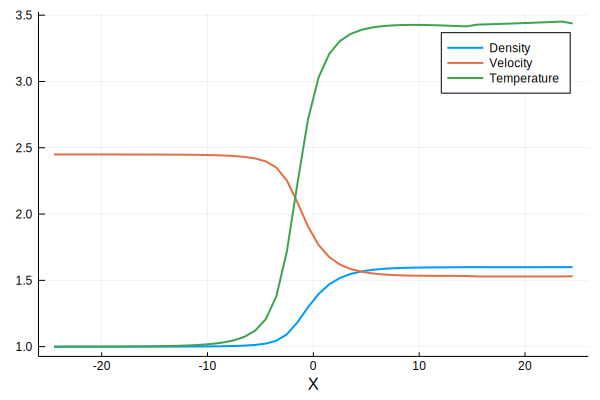

In [77]:
plot_line(ks, ctr)

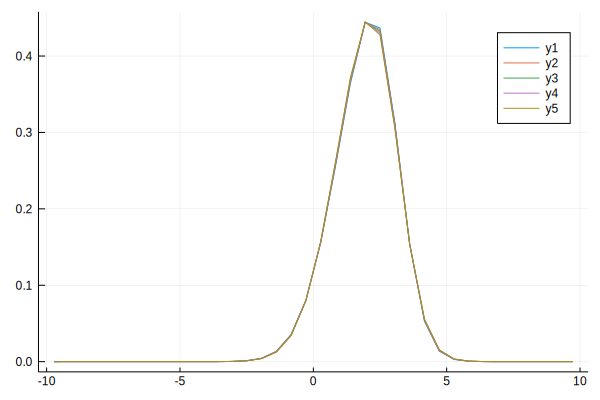

In [39]:
plot(vSpace.u, node(ctr[25].f[1:end], res.minimizer).u)

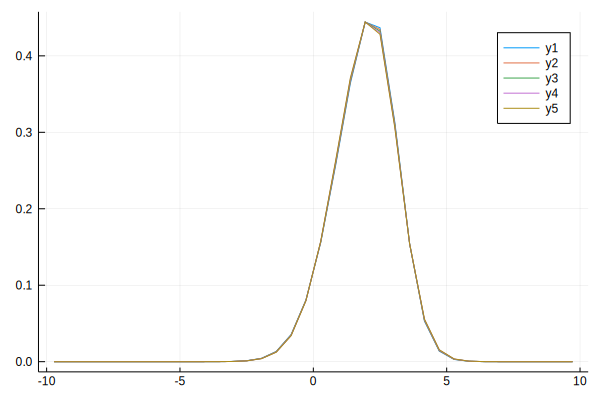

In [42]:
plot(vSpace.u, Y[:,25,:])